In [59]:
! pip install pyspark

In [86]:
from pyspark.sql import SparkSession, DataFrame, functions as F
from pyspark.ml.feature import Imputer, StringIndexer, VectorIndexer, VectorAssembler, OneHotEncoder, PCA, Bucketizer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
import pandas as pd
#import pandas_profiling
import os


for dirname, _, filenames in os.walk('Titanic'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Titanic/test.csv
Titanic/train.csv
Titanic/gender_submission.csv


In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
spark = SparkSession.builder.appName("Titanic-Dataset").config('spark.driver.memory','15g').getOrCreate()
spark

In [63]:
sdf_train = spark.read.csv('Titanic/train.csv', inferSchema=True, header=True)
sdf_test = spark.read.csv('Titanic/test.csv', inferSchema=True, header=True)
sdf_train.show(5)
sdf_test.show(5)
sdf_train.printSchema()
sdf_test.printSchema()
sdf_train.describe().show()
sdf_test.describe().show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [64]:
def _clean_dataset(sdf: DataFrame, col_to_convert: list, col_to_impute: list) -> DataFrame:
    for col in col_to_convert:
        sdf = sdf.withColumn(col,sdf[col].cast('double'))
    col_to_impute += col_to_convert

    imputer = Imputer(inputCols = col_to_impute, outputCols = col_to_impute)
    sdf = imputer.fit(sdf).transform(sdf)
    
    return sdf    

In [65]:
def _handle_missing_age(sdf: DataFrame) -> DataFrame:
    _sdf = sdf
    _sdf = _sdf.withColumn('Age', 
           F.when((F.isnull(_sdf['Age'])) & (_sdf['Initial'] == 'Mr') , 33 )\
            .otherwise(F.when((F.isnull(_sdf['Age'])) 
                              & (_sdf['Initial'] == 'Mrs') , 36)\
            .otherwise(F.when((F.isnull(_sdf['Age'])) 
                              & (_sdf['Initial'] == 'Master') , 5)\
            .otherwise(F.when((F.isnull(_sdf['Age'])) 
                              & (_sdf['Initial'] == 'Miss') , 22)\
            .otherwise(F.when((F.isnull(_sdf['Age'])) 
                              & (_sdf['Initial'] == 'Other') , 46)\
            .otherwise(_sdf['Age']) )))))
    return _sdf

In [66]:
def _evaluate_initials(sdf: DataFrame) -> DataFrame:
    dizip_initials = {k:v for k,v in (zip(['Mlle','Mme','Ms','Dr',
                                           'Major','Lady','Countess',
                                           'Jonkheer','Col','Rev',
                                           'Capt','Sir','Don'],
                                         ['Miss','Miss','Miss',
                                          'Mr','Mr','Mrs','Mrs',
                                          'Other','Other','Other',
                                          'Mr','Mr','Mr']))}
    _sdf = sdf.withColumn('Initial',  F.regexp_extract( sdf['Name'], ('([A-Za-z]+)\.'),1 ) )
    _sdf = _sdf.replace(dizip_initials,1,'Initial')
    return _sdf

In [67]:
def _create_family_size(sdf: DataFrame) -> DataFrame :
    _sdf = sdf.withColumn('FamilySize', sdf['Parch'] + sdf['SibSp'] + 1 )
    
    return _sdf

In [68]:
sdf_train_cleaned = _clean_dataset (_handle_missing_age(_evaluate_initials(_create_family_size(sdf_train) )),['Ticket','SibSp','Parch'],['Fare'])

sdf_test_cleaned = _clean_dataset ( 
    _handle_missing_age(
    _evaluate_initials(
    _create_family_size(sdf_test)
    )) 
    ,['Ticket','SibSp','Parch'],['Fare'] 
)

sdf_train_cleaned.limit(5).toPandas().T

/opt/homebrew/Caskroom/miniforge/base/envs/deepenv/lib/python3.9/site-packages/pyspark/sql/dataframe.py:4671: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1.0,1.0,0.0,1.0,0.0
Parch,0.0,0.0,0.0,0.0,0.0
Ticket,260318.549168,260318.549168,260318.549168,113803.0,373450.0
Fare,7.25,71.2833,7.925,53.1,8.05


In [69]:
sdf_train.limit(5).toPandas().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


In [70]:
pdf_sdf_train = sdf_train_cleaned.toPandas()
pdf_sdf_train.T

,0,1,2,3,4,5,6,7,8,9,...,881,882,883,884,885,886,887,888,889,890
PassengerId,1,2,3,4,5,6,7,8,9,10,...,882,883,884,885,886,887,888,889,890,891
Survived,0,1,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,1,0
Pclass,3,1,3,1,3,3,1,3,3,2,...,3,3,2,3,3,2,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry","Moran, Mr. James","McCarthy, Mr. Timothy J","Palsson, Master. Gosta Leonard","Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)","Nasser, Mrs. Nicholas (Adele Achem)",...,"Markun, Mr. Johann","Dahlberg, Miss. Gerda Ulrika","Banfield, Mr. Frederick James","Sutehall, Mr. Henry Jr","Rice, Mrs. William (Margaret Norton)","Montvila, Rev. Juozas","Graham, Miss. Margaret Edith","""Johnston, Miss. Catherine Helen """"Carrie""""""","Behr, Mr. Karl Howell","Dooley, Mr. Patrick"
Sex,male,female,female,female,male,male,male,male,female,female,...,male,female,male,male,female,male,female,female,male,male
Age,22.0,38.0,26.0,35.0,35.0,33.0,54.0,2.0,27.0,14.0,...,33.0,22.0,28.0,25.0,39.0,27.0,19.0,22.0,26.0,32.0
SibSp,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Parch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0
Ticket,260318.549168,260318.549168,260318.549168,113803.0,373450.0,330877.0,17463.0,349909.0,347742.0,237736.0,...,349257.0,7552.0,260318.549168,260318.549168,382652.0,211536.0,112053.0,260318.549168,111369.0,370376.0
Fare,7.25,71.2833,7.925,53.1,8.05,8.4583,51.8625,21.075,11.1333,30.0708,...,7.8958,10.5167,10.5,7.05,29.125,13.0,30.0,23.45,30.0,7.75


Text(0.5, 1.0, 'violinplot: Age ratio with Initial')

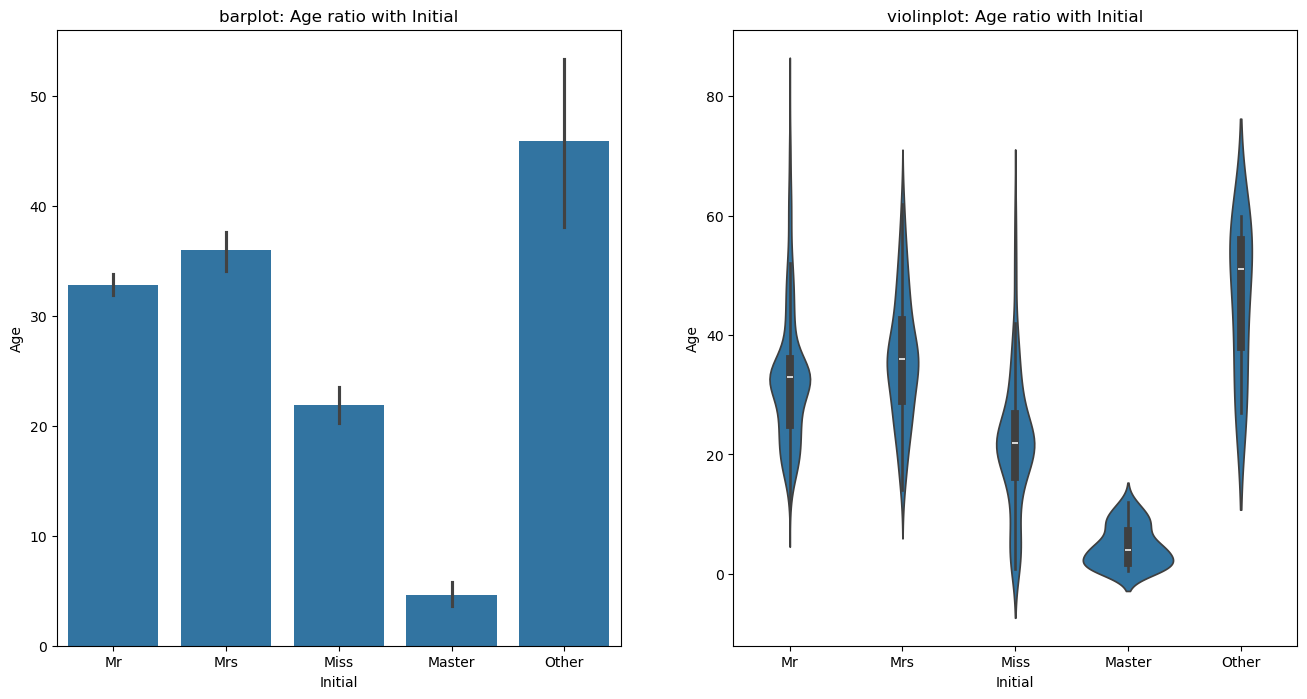

In [71]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('barplot: Age ratio with Initial')
sns.barplot(x= pdf_sdf_train['Initial'], y=pdf_sdf_train['Age'],ax=ax[0])

sns.violinplot(x='Initial', y='Age', data=pdf_sdf_train, ax=ax[1])

# Setting the title of the plot
ax[1].set_title('violinplot: Age ratio with Initial')

In [72]:
pdf_sdf_train['AgeGroup'] = None
pdf_sdf_train.loc[((pdf_sdf_train['Sex'] == 'male') & (pdf_sdf_train['Age'] <= 15)), 'AgeGroup'] = 'boy'
pdf_sdf_train.loc[((pdf_sdf_train['Sex'] == 'female') & (pdf_sdf_train['Age'] <= 15)), 'AgeGroup'] = 'girl'
pdf_sdf_train.loc[((pdf_sdf_train['Sex'] == 'male') & (pdf_sdf_train['Age'] > 15)), 'AgeGroup'] = 'adult male'
pdf_sdf_train.loc[((pdf_sdf_train['Sex'] == 'female') & (pdf_sdf_train['Age'] > 15)), 'AgeGroup'] = 'adult female'
pdf_sdf_train['AgeGroup'].value_counts()

AgeGroup
adult male      533
adult female    271
boy              44
girl             43
Name: count, dtype: int64

<Axes: title={'center': 'countplot: Survived ratio for Age group'}, xlabel='AgeGroup', ylabel='count'>

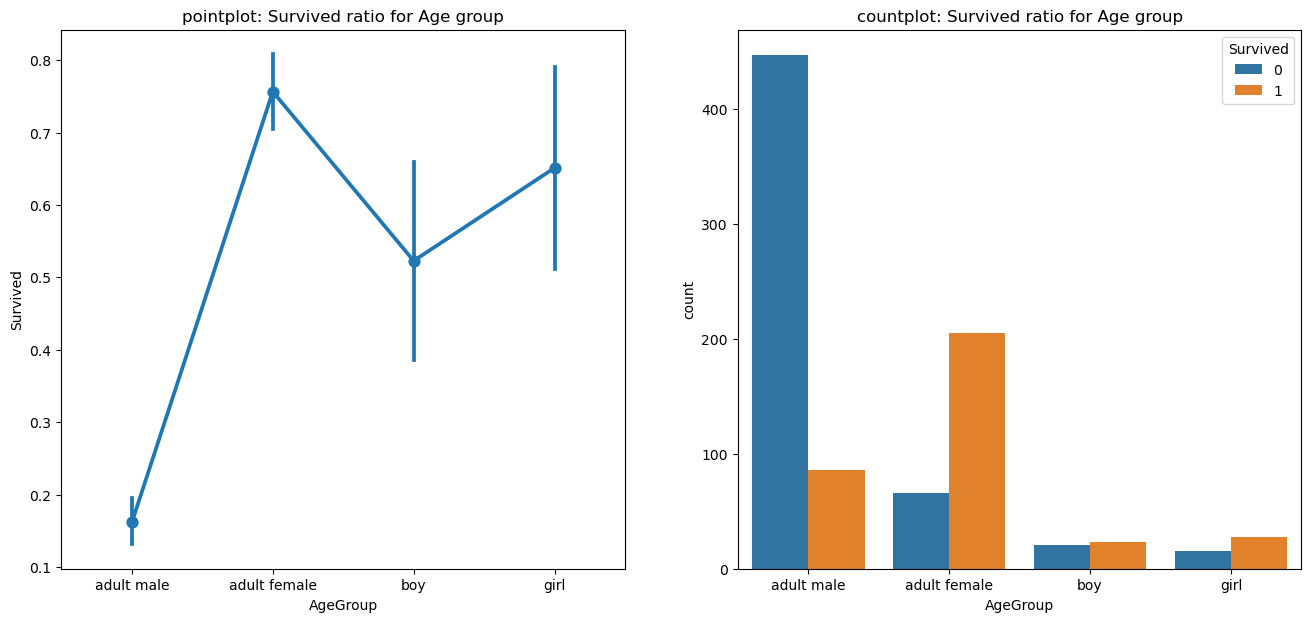

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Create a point plot
ax[0].set_title('pointplot: Survived ratio for Age group')
sns.pointplot(x='AgeGroup', y='Survived', data=pdf_sdf_train, ax=ax[0])

# Create a count plot
ax[1].set_title('countplot: Survived ratio for Age group')
sns.countplot(x='AgeGroup', hue='Survived', data=pdf_sdf_train, ax=ax[1])

<Axes: title={'center': 'countplot: Survived ratio with Pclass'}, xlabel='Pclass', ylabel='count'>

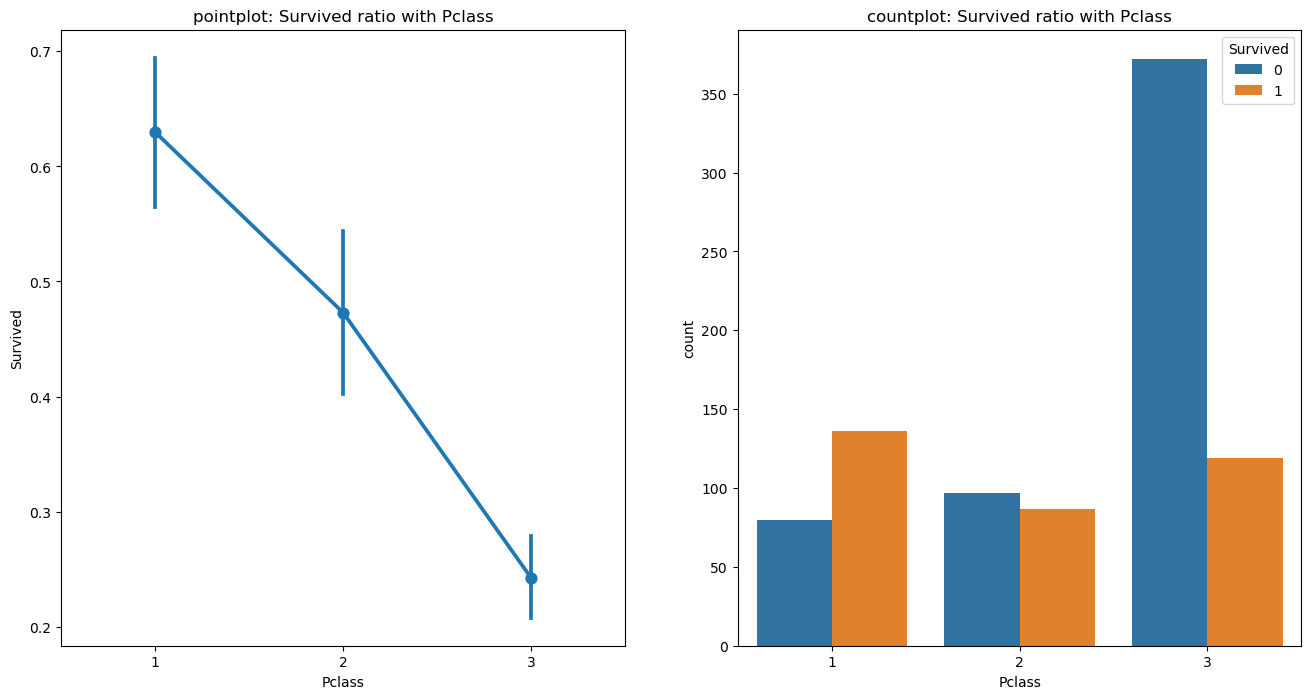

In [74]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].set_title('pointplot: Survived ratio with Pclass')
sns.pointplot(x ='Pclass',y='Survived', data=pdf_sdf_train, ax=ax[0])
ax[1].set_title('countplot: Survived ratio with Pclass')
sns.countplot(x ='Pclass',hue='Survived', data=pdf_sdf_train, ax=ax[1])

In [75]:
pd.Categorical(pdf_sdf_train['Sex'])


['male', 'female', 'female', 'female', 'male', ..., 'male', 'female', 'female', 'male', 'male']
Length: 891
Categories (2, object): ['female', 'male']

16
65


/var/folders/54/0ppv1xbn2h99kqvlhvh3sd3r0000gn/T/ipykernel_13795/3490624476.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Age', y='Survived', data=pdf_sdf_train, ci=None)


<Axes: xlabel='Age', ylabel='Survived'>

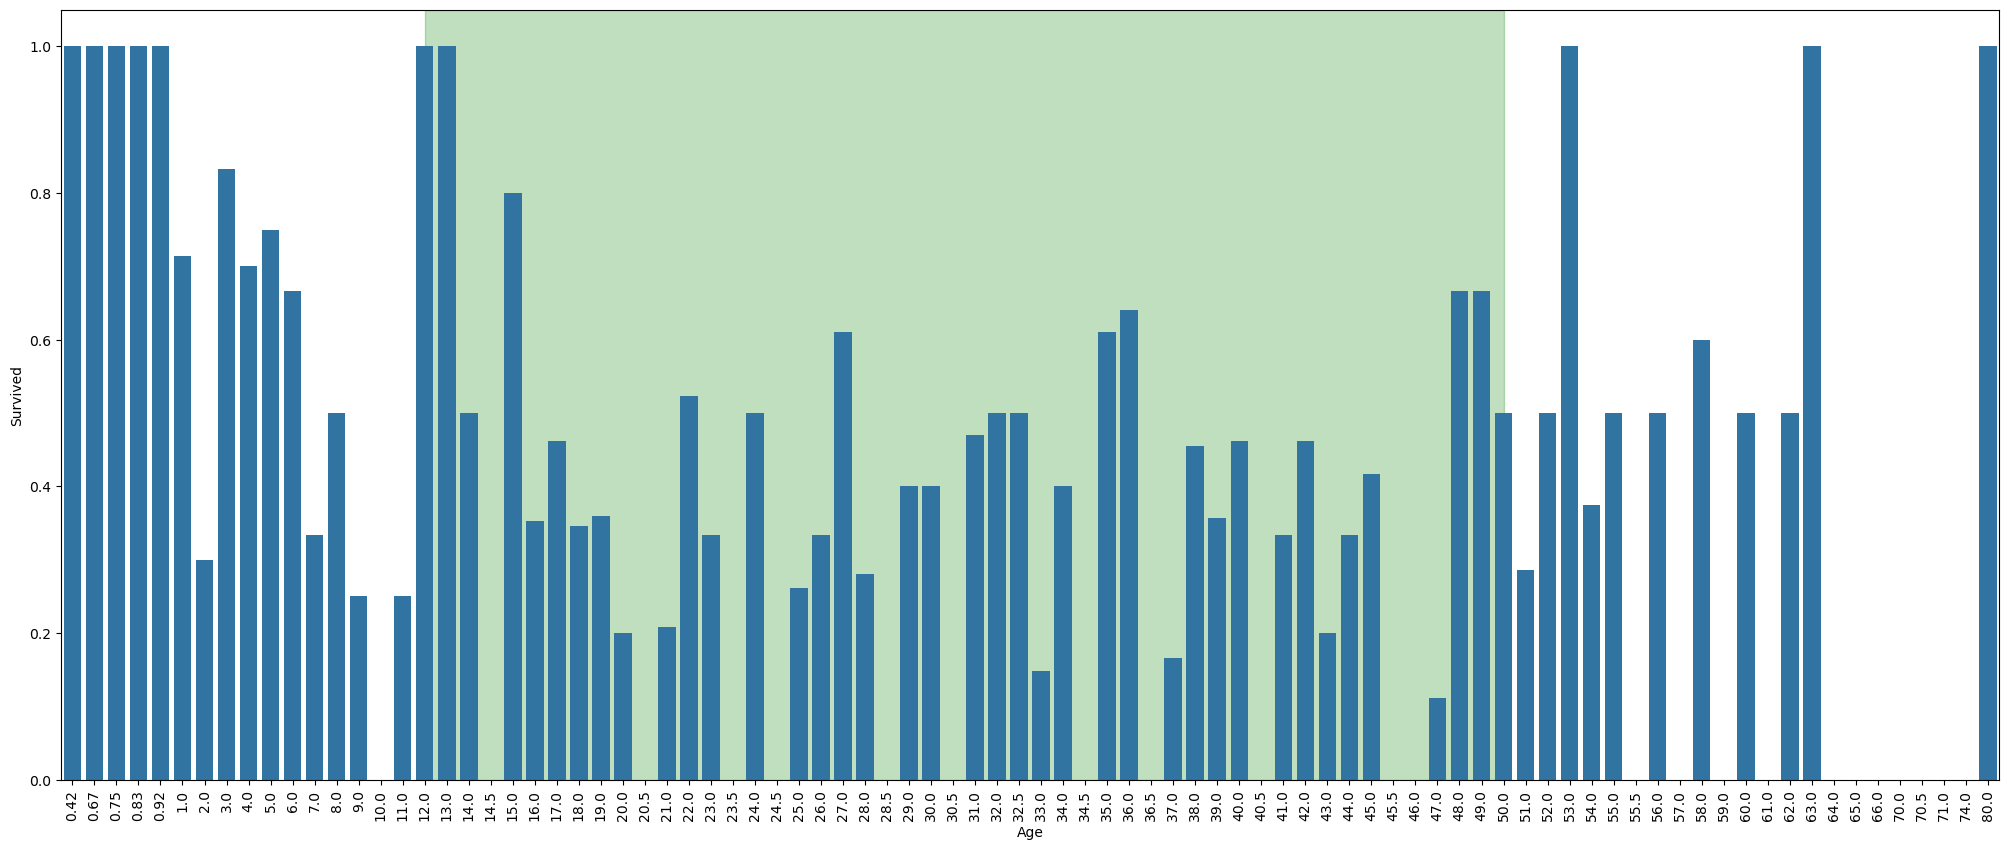

In [76]:
import numpy as np
plt.figure(figsize=(25,10))
plt.xticks(rotation=90)
plt.axvspan(np.size(pdf_sdf_train[pdf_sdf_train['Age'] < 12]['Age'].unique())
            ,np.size(pdf_sdf_train[pdf_sdf_train['Age'] < 50]['Age'].unique())
            ,alpha = 0.25
            , color = 'green') # without alpha = 0.25, it will be dark green!
print(np.size(pdf_sdf_train[pdf_sdf_train['Age'] < 12]['Age'].unique()))
print(np.size(pdf_sdf_train[pdf_sdf_train['Age'] < 50]['Age'].unique()))

sns.barplot(x='Age', y='Survived', data=pdf_sdf_train, ci=None)

<Axes: title={'center': 'countplot: Survived ratio with Pclass'}, xlabel='Pclass', ylabel='count'>

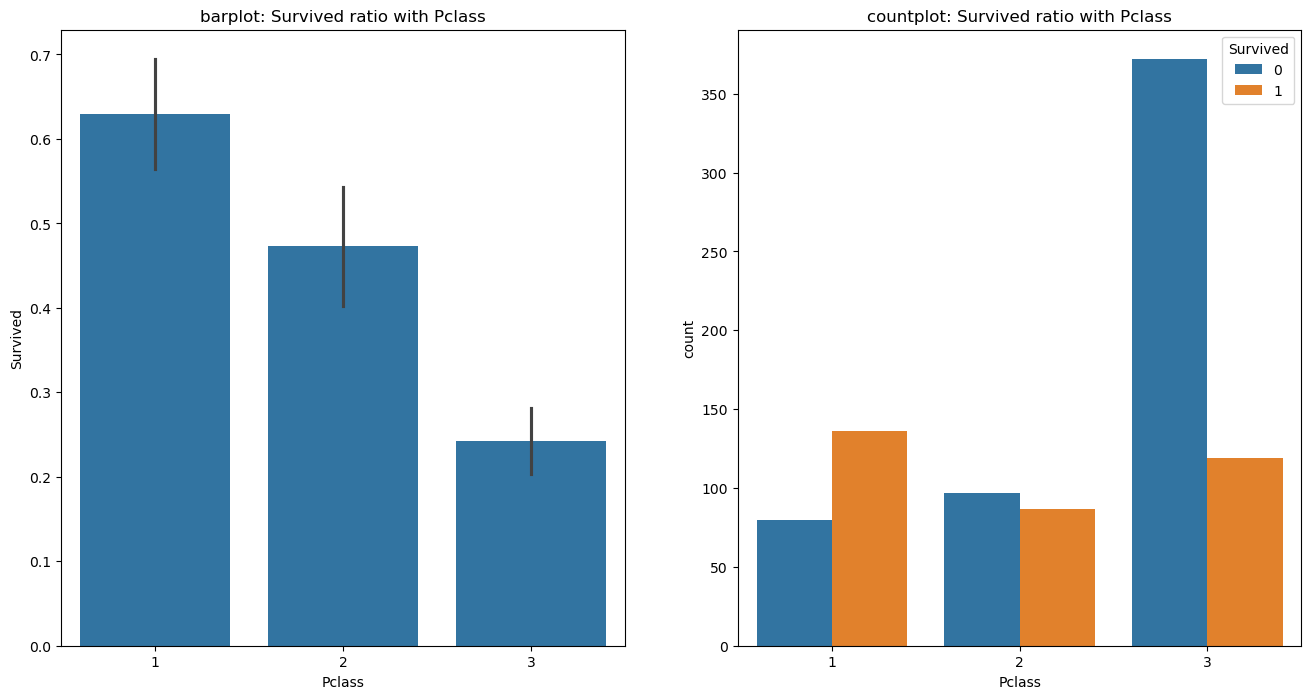

In [77]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('barplot: Survived ratio with Pclass')
sns.barplot( x= 'Pclass', y='Survived', data = pdf_sdf_train, ax=ax[0])

ax[1].set_title('countplot: Survived ratio with Pclass')
sns.countplot(x= 'Pclass', hue='Survived', data = pdf_sdf_train, ax=ax[1])

/var/folders/54/0ppv1xbn2h99kqvlhvh3sd3r0000gn/T/ipykernel_13795/2707184667.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pdf_sdf_train['Age'])


<Axes: title={'center': 'Age distribution among all Pasengers'}, xlabel='Age', ylabel='Density'>

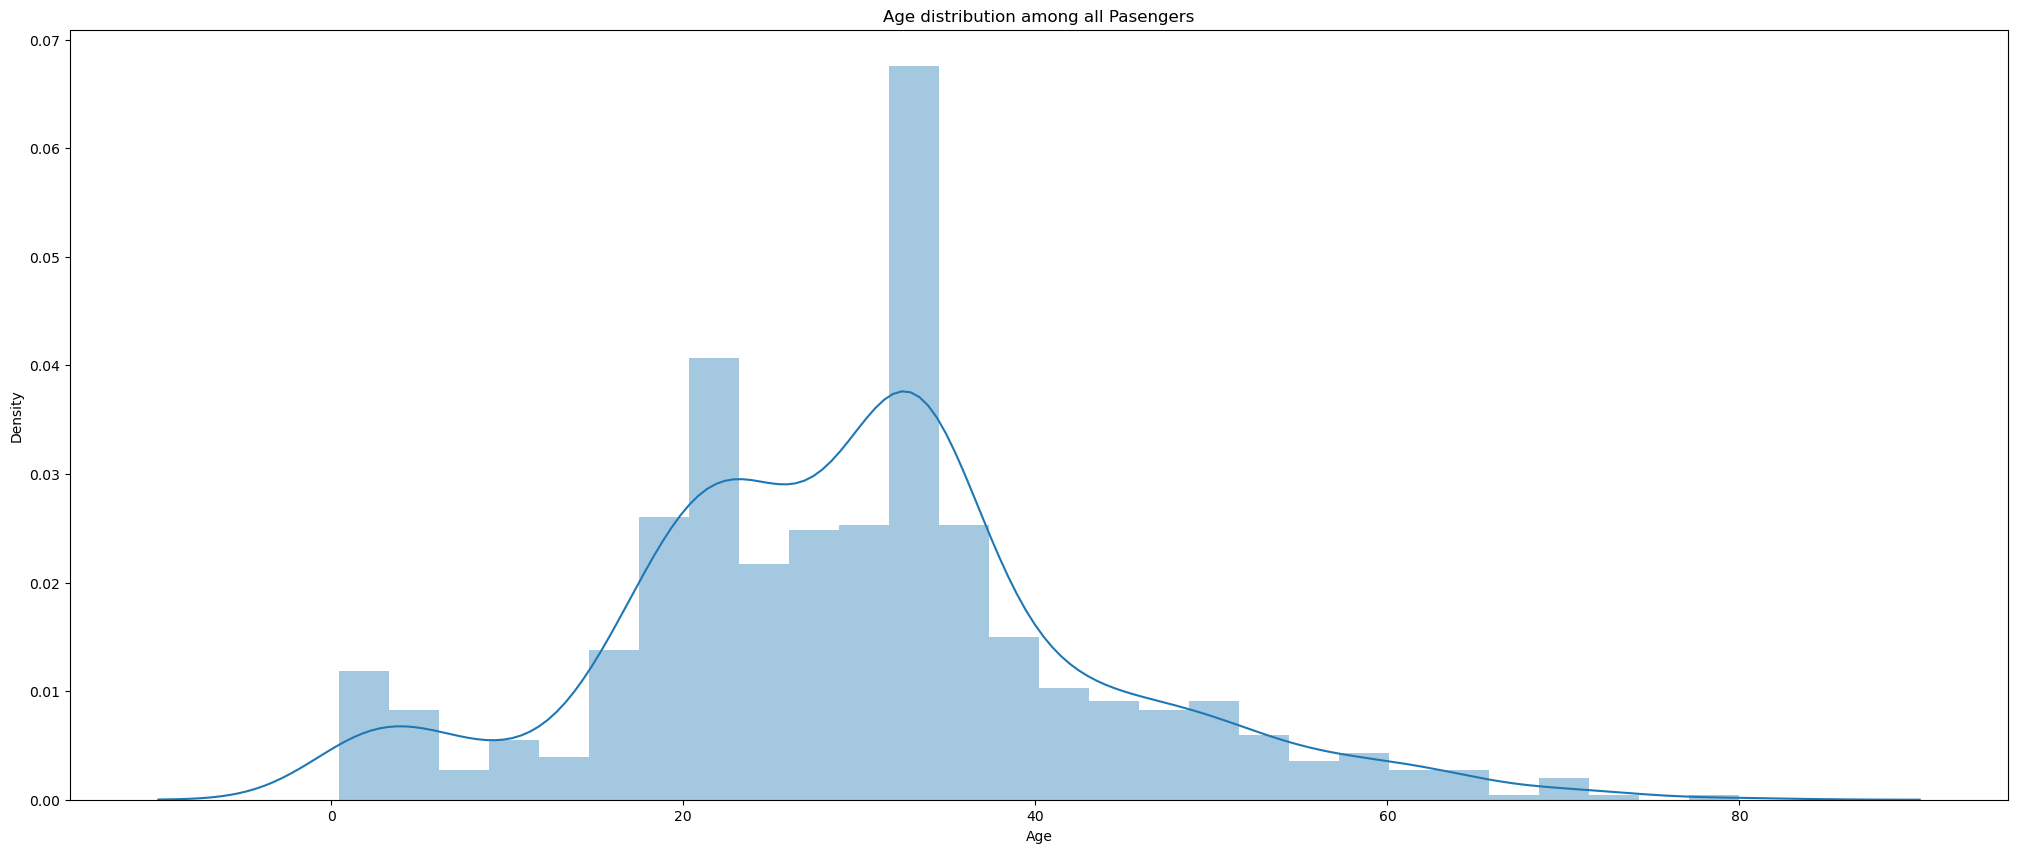

In [78]:
plt.figure(figsize=(25,10))
plt.title('Age distribution among all Pasengers')
sns.distplot(pdf_sdf_train['Age'])

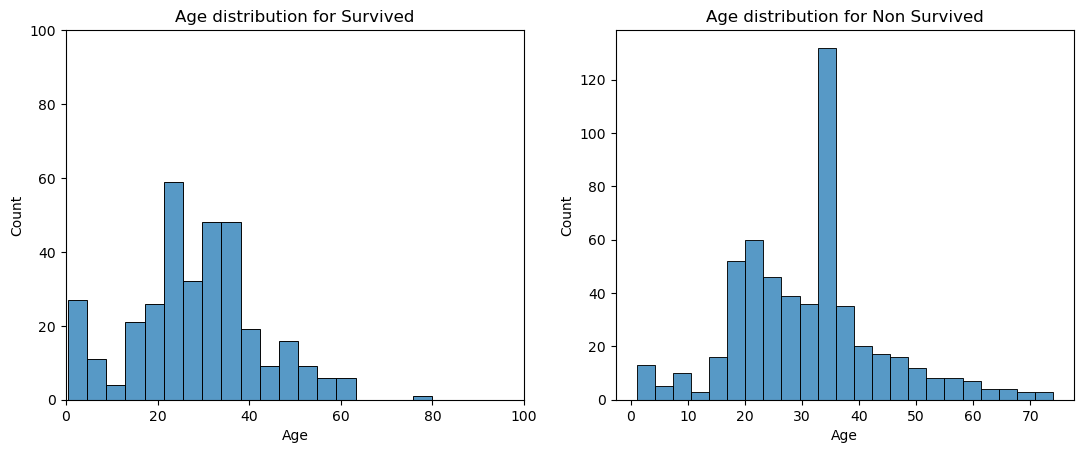

In [79]:
plt.subplot(1,2,1)
# plt.figure(figsize=(25,10))
plt.title('Age distribution for Survived')
plt.axis([0,100,0,100])
sns.histplot(pdf_sdf_train[pdf_sdf_train.Survived == 1]['Age'],kde=False)

plt.subplot(1,2,2)
plt.title('Age distribution for Non Survived')
sns.histplot(pdf_sdf_train[pdf_sdf_train.Survived == 0]['Age'],kde=False)

plt.subplots_adjust(right=1.7)

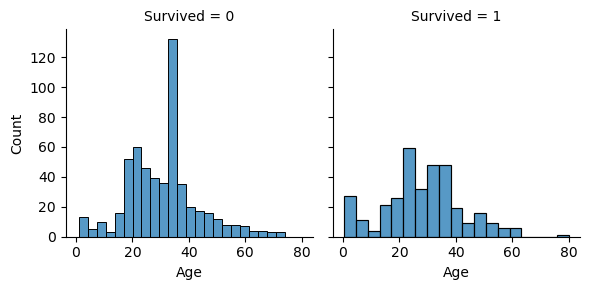

In [80]:
g = sns.FacetGrid(pdf_sdf_train,col='Survived')
g = g.map(sns.histplot,'Age')

/var/folders/54/0ppv1xbn2h99kqvlhvh3sd3r0000gn/T/ipykernel_13795/3614464603.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(pdf_sdf_train['Age']
/var/folders/54/0ppv1xbn2h99kqvlhvh3sd3r0000gn/T/ipykernel_13795/3614464603.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(pdf_sdf_train['Age']


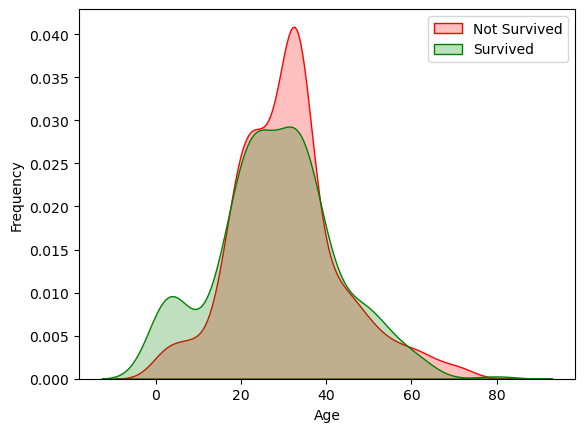

In [81]:
g = sns.kdeplot(pdf_sdf_train['Age']
                [(pdf_sdf_train['Survived']==0) 
                                     & (pdf_sdf_train['Age'].notnull())],
                color='Red',shade=True)
g = sns.kdeplot(pdf_sdf_train['Age']
                [(pdf_sdf_train['Survived']==1)  
                                     & (pdf_sdf_train['Age'].notnull())],
                color='Green',shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

<Axes: xlabel='Survived', ylabel='Age'>

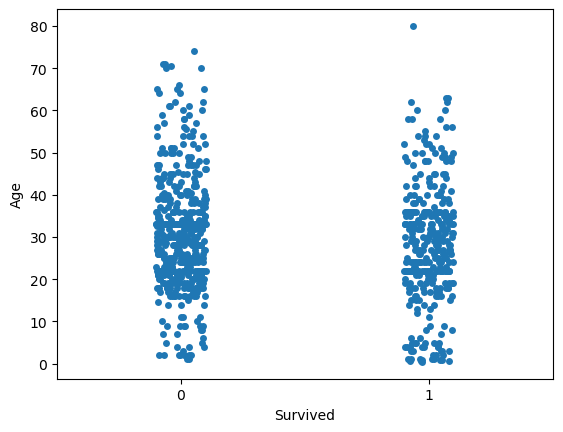

In [90]:
sns.stripplot(x="Survived", y="Age",data=pdf_sdf_train,jitter=True)


In [82]:
numeric_cols = ['PassengerId','Survived', 'Pclass',
                'Age', 'SibSp','Parch','Ticket','Fare'] 
numeric_features = ['PassengerId','Pclass','Age', 'SibSp','Parch','Fare'] 
string_features = [ 'Embarked', 'Sex'] 

In [87]:
_stages = []
string_indexer =  [StringIndexer(inputCol = column , \
                                 outputCol = column + '_StringIndexer', 
                                 handleInvalid = "skip") for column in string_features]

one_hot_encoder = [OneHotEncoder(
    inputCols = [column + '_StringIndexer' for column in string_features ], \
    outputCols =  [column + '_OneHotEncoderEstimator' for column in string_features ])]

vect_indexer = [VectorIndexer(
    inputCol = column + '_OneHotEncoderEstimator',
    outputCol = column + '_VectorIndexer', 
    maxCategories=10) for column in string_features]

familt_size_splits = [1, 2, 5, 7, 100] 
bucketizer = Bucketizer(splits = familt_size_splits, 
                        inputCol = 'FamilySize',
                        outputCol = 'bucketized_FamilySize')

numeric_features += ['bucketized_FamilySize']

assemblerInput =  [f  for f in numeric_features]  
assemblerInput += [f + "_VectorIndexer" for f in string_features]
vector_assembler = VectorAssembler(inputCols = assemblerInput, \
                                   outputCol = 'VectorAssembler_features')

_stages += string_indexer
_stages += one_hot_encoder
_stages += vect_indexer
_stages += [bucketizer]
_stages += [vector_assembler]

In [88]:
_stages

[StringIndexer_5e34215aff72,
 StringIndexer_08d6f7dd39d7,
 OneHotEncoder_0cf1b7642b59,
 VectorIndexer_7c31d475fc17,
 VectorIndexer_20c4b21d7cc7,
 Bucketizer_579e8bc57cff,
 VectorAssembler_850cf800c0a1]

In [89]:
pipeline = Pipeline(stages = _stages)

In [92]:
model = pipeline.fit(sdf_train_cleaned)
sdf_transformed_train = model.transform(sdf_train_cleaned)
sdf_transformed_train.limit(5).toPandas().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1.0,1.0,0.0,1.0,0.0
Parch,0.0,0.0,0.0,0.0,0.0
Ticket,260318.549168,260318.549168,260318.549168,113803.0,373450.0
Fare,7.25,71.2833,7.925,53.1,8.05


In [93]:
rf = RandomForestClassifier(labelCol = 'Survived', 
                            featuresCol = 'VectorAssembler_features', 
                            numTrees = 100, 
                            maxDepth = 4, 
                            maxBins = 1000)
_stages += [rf]

In [94]:
_stages

[StringIndexer_5e34215aff72,
 StringIndexer_08d6f7dd39d7,
 OneHotEncoder_0cf1b7642b59,
 VectorIndexer_7c31d475fc17,
 VectorIndexer_20c4b21d7cc7,
 Bucketizer_579e8bc57cff,
 VectorAssembler_850cf800c0a1,
 RandomForestClassifier_a676111017c9]

In [95]:
pipeline = Pipeline(stages = _stages)
model = pipeline.fit(sdf_train_cleaned)

sdf_predict = model.transform(sdf_test_cleaned)

24/08/02 17:23:22 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 1000 to 889 (= number of training instances)


In [102]:
!pip install pydantic-settings



In [103]:
!pip install pandas-profiling


In [106]:
import pandas_profiling

sdf_predict.toPandas().profile_report()


PydanticImportError: `BaseSettings` has been moved to the `pydantic-settings` package. See https://docs.pydantic.dev/2.7/migration/#basesettings-has-moved-to-pydantic-settings for more details.

For further information visit https://errors.pydantic.dev/2.7/u/import-error